In [121]:
import sys

In [122]:
sys.path.append("../code/")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys, traceback
print sys.argv
from docopt import docopt
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict, create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, prepare_df_factorisation,prepare_known_features, create_matrix_factorised, create_prediction

['/Users/nipunbatra/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py', '-f', '/Users/nipunbatra/Library/Jupyter/runtime/kernel-6d24d980-c3c9-475e-9ec1-3ef4790ed501.json']


In [10]:
year=2014
seed = 0
test_home=54
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['SanDiego']=1.0
test_region = 'SanDiego'
feature_list = ['energy','home']
appliance="hvac"
feature_comb = ['None']
lat = 1

In [81]:
def f(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                        idx_user=idx_user, data_user=data_user,
                         idx_item=idx_item, data_item=data_item, MAX_ITERS=10)
    return X, Y, res, df
    


In [82]:
X_fridge_sd, Y_fridge_sd, res_sd, df_fridge_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "fridge", feature_comb, lat)
X_hvac_sd, Y_hvac_sd, res_sd, df_hvac_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "hvac", feature_comb, lat)

In [83]:
X_fridge_austin, Y_fridge_austin, res_sd, df_fridge_austin = f(year, seed, 22, train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, "fridge", feature_comb, lat)
X_hvac_austin, Y_hvac_austin, res_sd, df_hvac_austin = f(year, seed, 22, train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, "hvac", feature_comb, lat)

In [74]:
X_fridge = pd.DataFrame({"Austin":np.array(X_fridge_austin).flatten(),'SanDiego':np.array(X_fridge_sd).flatten()})
X_hvac = pd.DataFrame({"Austin":np.array(X_hvac_austin).flatten(),'SanDiego':np.array(X_hvac_sd).flatten()})

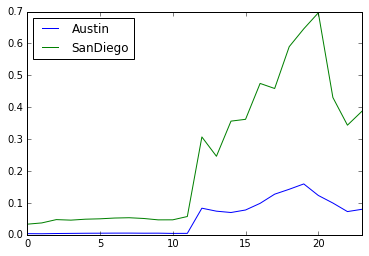

In [120]:
X_fridge.plot()


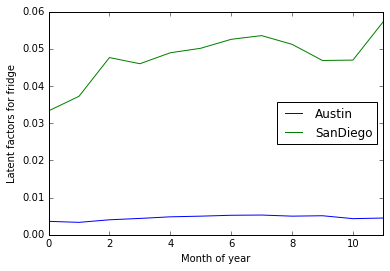

In [75]:
X_fridge[:12].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for fridge")

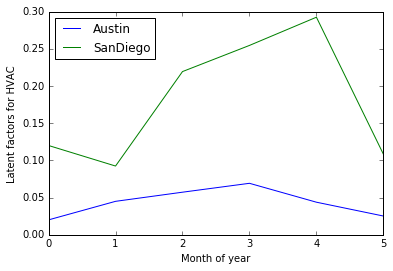

In [76]:
X_hvac[:6].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for HVAC")

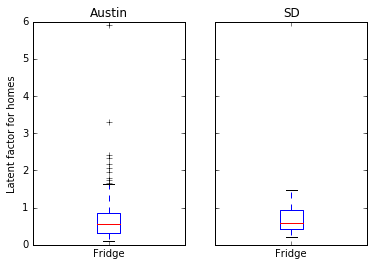

In [77]:
fig, ax = plt.subplots(ncols=2, sharey=True)
pd.DataFrame(Y_fridge_austin).squeeze().plot(kind="box", ax=ax[0], title="Austin", label="Fridge")
ax[0].set_ylabel("Latent factor for homes")
pd.DataFrame(Y_fridge_sd).squeeze().plot(kind="box", ax=ax[1], title="SD", label="Fridge")


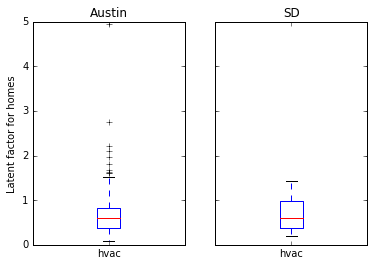

In [78]:
fig, ax = plt.subplots(ncols=2, sharey=True)
pd.DataFrame(Y_hvac_austin).squeeze().plot(kind="box", ax=ax[0], title="Austin", label="hvac")
ax[0].set_ylabel("Latent factor for homes")
pd.DataFrame(Y_hvac_sd).squeeze().plot(kind="box", ax=ax[1], title="SD", label="hvac")


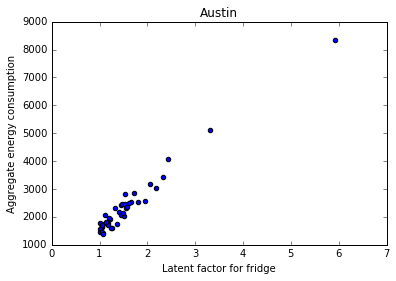

In [114]:
t = pd.DataFrame(Y_fridge_austin)
t.index = df_fridge_austin.index
plt.scatter(t[t>1].dropna(), df_fridge_austin.ix[t[t>1].dropna().index]['aggregate_6'])
plt.ylabel("Aggregate energy consumption")
plt.xlabel("Latent factor for fridge")
plt.title("Austin")

In [116]:
df_fridge_austin.ix[t[t>0].dropna().index]['aggregate_6'].median()

817.7833557128906

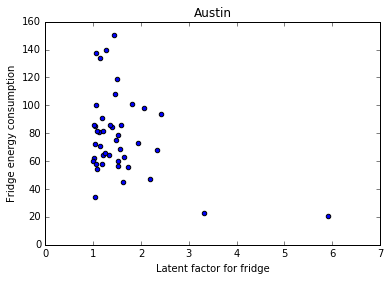

In [118]:
t = pd.DataFrame(Y_fridge_austin)
t.index = df_fridge_austin.index
plt.scatter(t[t>1].dropna(), df_fridge_austin.ix[t[t>1].dropna().index]['fridge_6'])
plt.ylabel("Fridge energy consumption")
plt.xlabel("Latent factor for fridge")
plt.title("Austin")

In [119]:
df_fridge_austin.ix[t[t>0].dropna().index]['fridge_6'].median()

52.76436805725098

In [65]:
from degree_days import *

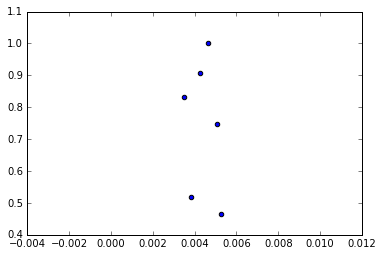

In [99]:
plt.scatter(X_df[:6]['Austin'],dds[2014]['Austin'][4:10] )
#dds[2014]['Austin'][4:9]

In [75]:
X_df[6:]['Austin']

6     0.107697
7     0.142078
8     0.160392
9     0.179684
10    0.140001
11    0.112244
Name: Austin, dtype: float64

In [100]:
dds[2014]['Austin']

[0.012706480304955527,
 0.07369758576874205,
 0.09148665819567979,
 0.30495552731893266,
 0.5184243964421855,
 0.832274459974587,
 0.9085133418043202,
 1.0,
 0.747141041931385,
 0.4650571791613723,
 0.054637865311308764,
 0.03430749682337993]

In [77]:
X_hvac_austin

matrix([[ 0.02039206,  0.04568984,  0.0581605 ,  0.07030242,  0.04450363,
          0.02562743,  0.10769739,  0.14207768,  0.16039202,  0.17968411,
          0.14000083,  0.11224388]])

In [78]:
Y_hvac_austin

matrix([[ 0.50037877],
        [ 0.25846533],
        [ 0.36190634],
        [ 0.18519378],
        [ 0.64164236],
        [ 0.91612977],
        [ 1.32820979],
        [ 0.23230988],
        [ 0.86287042],
        [ 0.81727218],
        [ 1.13134948],
        [ 0.50779661],
        [ 0.34748687],
        [ 0.71765476],
        [ 0.31554283],
        [ 1.34911238],
        [ 0.97815815],
        [ 0.64037072],
        [ 0.2986775 ],
        [ 0.33094265],
        [ 0.90171486],
        [ 0.76396439],
        [ 0.14776769],
        [ 0.60846783],
        [ 0.40045271],
        [ 0.5417921 ],
        [ 0.78199659],
        [ 0.78248434],
        [ 0.54114435],
        [ 0.39263816],
        [ 0.85281926],
        [ 1.60223993],
        [ 1.42374286],
        [ 0.98733554],
        [ 0.93638901],
        [ 4.87566995],
        [ 0.64647819],
        [ 0.11859901],
        [ 0.86203369],
        [ 0.70657032],
        [ 1.19760582],
        [ 1.08471411],
        [ 0.4528264 ],
        [ 0

In [101]:
idx_user

In [102]:
data_user

In [70]:
from common_functions import valid_homes_data

In [71]:
valid_homes_data

{'Austin': {'fridge': array([  22,   26,   48,   59,   68,   86,   93,   94,  101,  114,  115,
          121,  130,  135,  160,  187,  222,  243,  267,  297,  347,  370,
          410,  434,  436,  457,  470,  484,  491,  499,  507,  508,  545,
          580,  624,  645,  661,  772,  781,  871,  878,  898,  936,  946,
          954,  980, 1037, 1069, 1086, 1105, 1169, 1185, 1310, 1314, 1334,
         1403, 1415, 1463, 1479, 1500, 1507, 1551, 1577, 1586, 1617, 1632,
         1642, 1697, 1700, 1782, 1796, 1801, 1854, 1889, 1947, 1953, 2004,
         2018, 2034, 2075, 2094, 2156, 2158, 2171, 2199, 2207, 2233, 2242,
         2247, 2335, 2361, 2365, 2366, 2378, 2458, 2461, 2465, 2470, 2520,
         2532, 2557, 2575, 2667, 2751, 2787, 2814, 2818, 2829, 2845, 2859,
         2864, 2907, 2953, 2965, 2974, 2992, 2995, 3032, 3036, 3039, 3044,
         3143, 3192, 3235, 3268, 3273, 3299, 3367, 3392, 3413, 3443, 3456,
         3482, 3500, 3504, 3519, 3538, 3577, 3631, 3649, 3652, 3678, 3721,
     